In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np
import seaborn as sns
import torch.nn as nn
import sys

from pathlib import Path
from fastai.vision import *
from fastai.basics import *
from fastai.callbacks import *
from google.colab import drive
from torchvision.models.resnet import *
from fastai import *
from torch import cuda

In [3]:
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/gdrive/My Drive')

Mounted at /content/drive


# Get data and assemble it

In [0]:
path = Path('/content/drive/My Drive/burn')
tfms = get_transforms(flip_vert=True)

In [0]:
df = pd.read_csv(path/'grossman_filtered', index_col=False)

In [0]:
data64 = ImageDataBunch.from_df(path/'images', df, label_col='label2', ds_tfms=tfms, size=64).normalize(imagenet_stats)
data128 = ImageDataBunch.from_df(path/'images', df, label_col='label2', ds_tfms=tfms, size=128).normalize(imagenet_stats)
data256 = ImageDataBunch.from_df(path/'images', df, label_col='label2', ds_tfms=tfms, size=256).normalize(imagenet_stats)

# Densenet-161

Best accuracy was ~80% without TTA

## size=64

In [0]:
learn0 = cnn_learner(data64, models.densenet161, metrics=[accuracy]).mixup().to_fp16()

In [34]:
learn0.fit_one_cycle(50, 1e-2, pct_start=0.3, callbacks=[SaveModelCallback(learn0, monitor='accuracy', name='161_64')])

Better model found at epoch 0 with accuracy value: 0.4453125.
Better model found at epoch 1 with accuracy value: 0.53515625.
Better model found at epoch 3 with accuracy value: 0.55078125.
Better model found at epoch 4 with accuracy value: 0.671875.
Better model found at epoch 7 with accuracy value: 0.6953125.
Better model found at epoch 9 with accuracy value: 0.69921875.
Better model found at epoch 27 with accuracy value: 0.70703125.
Better model found at epoch 31 with accuracy value: 0.71484375.


In [35]:
accuracy(*learn0.get_preds())

tensor(0.7148)

## size=128

In [0]:
learn0.to_fp32()
learn0.data = data128
learn0.to_fp16()

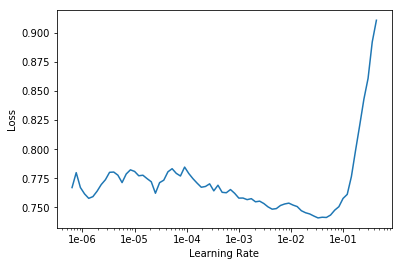

In [10]:
learn0.recorder.plot()

In [37]:
learn0.fit_one_cycle(50, 1e-2, pct_start=0.3, callbacks=[SaveModelCallback(learn0, monitor='accuracy', name='161_128')])

Better model found at epoch 0 with accuracy value: 0.69140625.
Better model found at epoch 1 with accuracy value: 0.6953125.
Better model found at epoch 2 with accuracy value: 0.7421875.
Better model found at epoch 3 with accuracy value: 0.76953125.


## size=256

In [38]:
learn0.to_fp32()
learn0.data = data256
learn0.to_fp16()
learn0.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


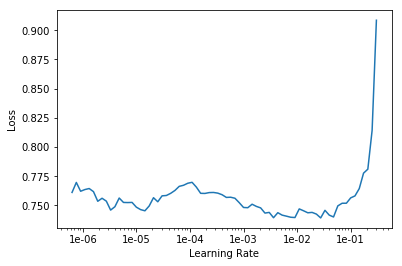

In [39]:
learn0.recorder.plot()

In [40]:
learn0.fit_one_cycle(50, 1e-3, pct_start=0.3, callbacks=[SaveModelCallback(learn0, monitor='accuracy', name='161_256')])

Better model found at epoch 0 with accuracy value: 0.7265625.
Better model found at epoch 1 with accuracy value: 0.73828125.
Better model found at epoch 3 with accuracy value: 0.74609375.
Better model found at epoch 4 with accuracy value: 0.75390625.
Better model found at epoch 6 with accuracy value: 0.7578125.
Better model found at epoch 8 with accuracy value: 0.765625.
Better model found at epoch 12 with accuracy value: 0.76953125.
Better model found at epoch 13 with accuracy value: 0.78125.
Better model found at epoch 14 with accuracy value: 0.78515625.
Better model found at epoch 16 with accuracy value: 0.79296875.
Better model found at epoch 23 with accuracy value: 0.796875.
Better model found at epoch 24 with accuracy value: 0.80078125.


In [41]:
accuracy(*learn0.get_preds())

tensor(0.8008)

## TTA

No improvement

In [42]:
learn0.to_fp32()
accs161 = []
for i in np.arange(0.7, 1.4, 0.05):
  accs161.append((i, accuracy(*learn0.TTA(scale=i))))
sorted(accs161, key = lambda k: k[1], reverse=True)

[(0.75, tensor(0.7891)),
 (1.0000000000000002, tensor(0.7891)),
 (1.1500000000000004, tensor(0.7891)),
 (1.1000000000000003, tensor(0.7852)),
 (0.7, tensor(0.7812)),
 (0.8, tensor(0.7812)),
 (0.8500000000000001, tensor(0.7812)),
 (0.9000000000000001, tensor(0.7812)),
 (1.2000000000000004, tensor(0.7812)),
 (1.2500000000000004, tensor(0.7812)),
 (0.9500000000000002, tensor(0.7773)),
 (1.0500000000000003, tensor(0.7773)),
 (1.3000000000000005, tensor(0.7773)),
 (1.3500000000000005, tensor(0.7734))]

## Interpretation

In general, there seems to be over-classification of things as second degree burns, which makes sense given that those are over-represented in the training data.  The top losses make more sense when we look at the heatmaps -- for several examples, the network is failing to identify the region that's most relevant.

In [0]:
interp0 = ClassificationInterpretation.from_learner(learn0)

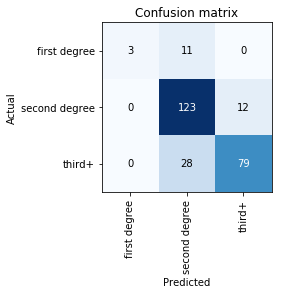

In [45]:
interp0.plot_confusion_matrix()

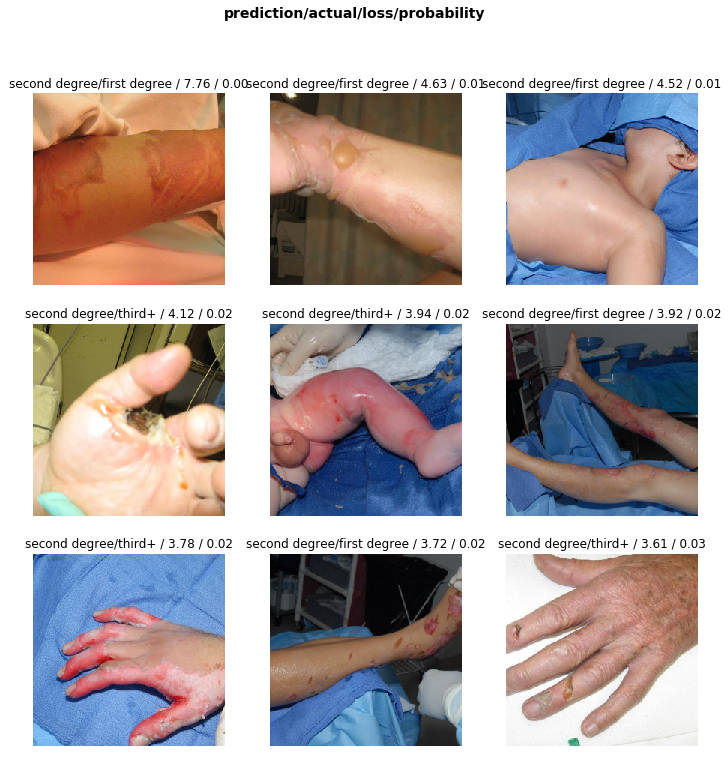

In [49]:
interp0.plot_top_losses(9, figsize=(12, 12), heatmap=False)

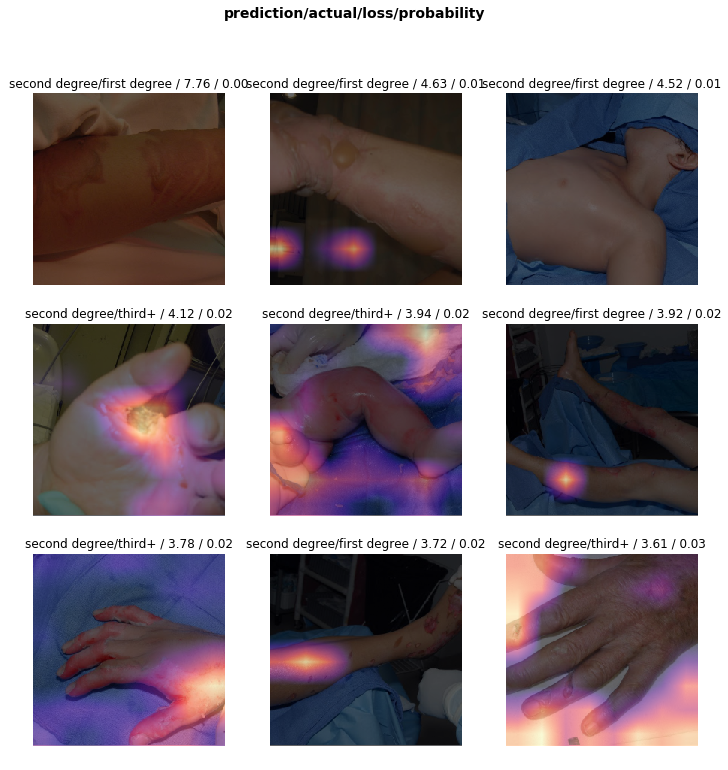

In [50]:
interp0.plot_top_losses(9, figsize=(12, 12), heatmap=True)

# Resnet-50

Best accuracy was ~80% with TTA scale=0.95

## size=64

In [51]:
learn1 = cnn_learner(data64, models.resnet50, metrics=[accuracy]).mixup().to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 22210353.07it/s]


In [52]:
learn1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


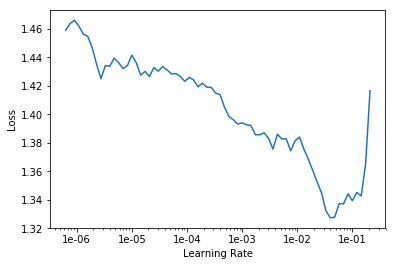

In [54]:
learn1.recorder.plot(skip_end=10)

In [55]:
learn1.fit_one_cycle(50, 1e-2, pct_start=0.3, callbacks=[SaveModelCallback(learn1, monitor='accuracy', name='50_64')])

Better model found at epoch 0 with accuracy value: 0.34765625.
Better model found at epoch 1 with accuracy value: 0.5390625.
Better model found at epoch 3 with accuracy value: 0.5703125.
Better model found at epoch 4 with accuracy value: 0.61328125.
Better model found at epoch 6 with accuracy value: 0.64453125.
Better model found at epoch 10 with accuracy value: 0.6796875.
Better model found at epoch 16 with accuracy value: 0.69921875.
Better model found at epoch 19 with accuracy value: 0.70703125.
Better model found at epoch 20 with accuracy value: 0.7109375.
Better model found at epoch 21 with accuracy value: 0.734375.


## size=128

In [56]:
learn1.to_fp32()
learn1.data = data128
learn1.to_fp16()
learn1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


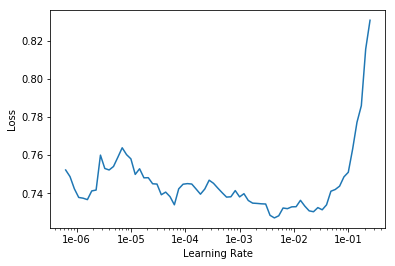

In [58]:
learn1.recorder.plot(skip_end=10)

In [59]:
learn1.fit_one_cycle(50, 1e-3, pct_start=0.3, callbacks=[SaveModelCallback(learn1, monitor='accuracy', name='50_128')])

Better model found at epoch 0 with accuracy value: 0.73046875.
Better model found at epoch 4 with accuracy value: 0.75390625.
Better model found at epoch 17 with accuracy value: 0.765625.
Better model found at epoch 21 with accuracy value: 0.77734375.


## size=256

In [60]:
learn1.to_fp32()
learn1.data = data256
learn1.to_fp16()
learn1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


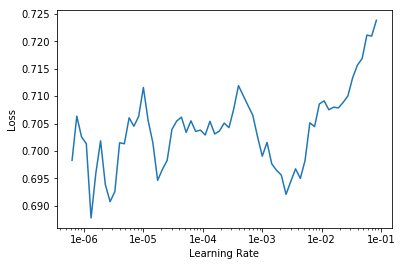

In [62]:
learn1.recorder.plot(skip_end=15)

In [63]:
learn1.fit_one_cycle(50, 1e-3, pct_start=0.3, callbacks=[SaveModelCallback(learn1, monitor='accuracy', name='50_256')])

Better model found at epoch 0 with accuracy value: 0.75390625.
Better model found at epoch 1 with accuracy value: 0.76171875.
Better model found at epoch 10 with accuracy value: 0.77734375.
Better model found at epoch 12 with accuracy value: 0.78125.
Better model found at epoch 16 with accuracy value: 0.80078125.


## TTA

In [64]:
learn1.to_fp32()
accs50 = []
for i in np.arange(0.7, 1.4, 0.05):
  accs50.append((i, accuracy(*learn1.TTA(scale=i))))
sorted(accs50, key = lambda k: k[1], reverse=True)

[(0.9500000000000002, tensor(0.8047)),
 (1.1000000000000003, tensor(0.8047)),
 (0.8500000000000001, tensor(0.7969)),
 (1.0500000000000003, tensor(0.7969)),
 (1.1500000000000004, tensor(0.7969)),
 (1.2500000000000004, tensor(0.7969)),
 (0.7, tensor(0.7930)),
 (0.8, tensor(0.7930)),
 (0.9000000000000001, tensor(0.7930)),
 (1.0000000000000002, tensor(0.7930)),
 (1.2000000000000004, tensor(0.7930)),
 (1.3000000000000005, tensor(0.7891)),
 (1.3500000000000005, tensor(0.7891)),
 (0.75, tensor(0.7852))]

## Interpretation

In [0]:
@classmethod
def ClassInterpVarScale(cls, learn:Learner, ds_type:DatasetType=DatasetType.Valid, tta=True, scale=1.3):
  "Create an instance of ClassificationInterpretation with tta scale=0.95"
  preds = learn.TTA(ds_type=ds_type, with_loss=True, scale=scale)
  return cls(learn, *preds, ds_type=ds_type)

ClassificationInterpretation.from_learner2 = ClassInterpVarScale

In [66]:
interp1 = ClassificationInterpretation.from_learner2(learn1, scale=0.95)

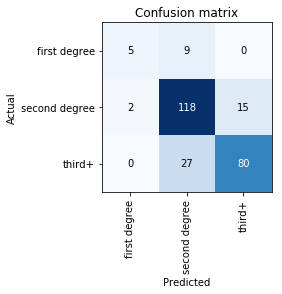

In [67]:
interp1.plot_confusion_matrix()

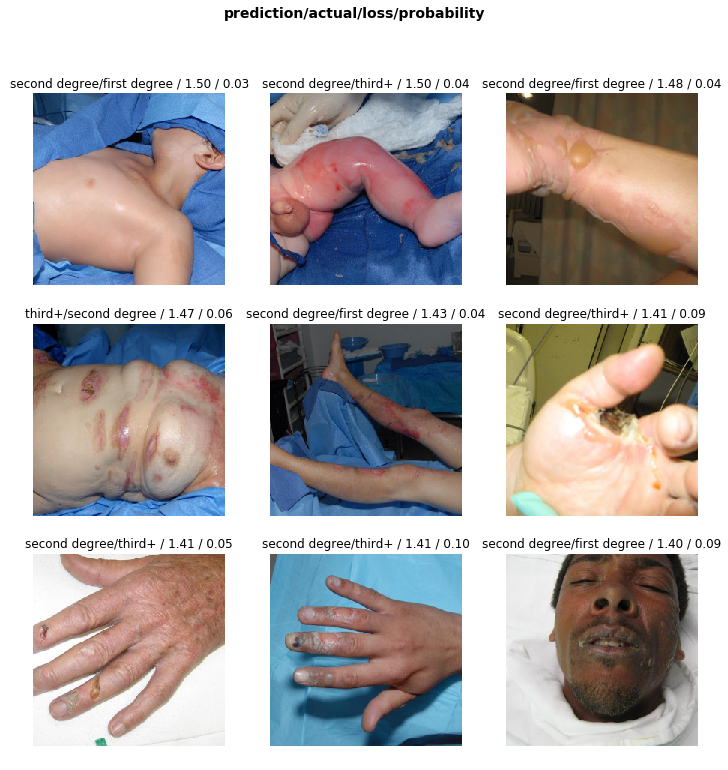

In [68]:
interp1.plot_top_losses(9, figsize=(12, 12), heatmap=False)

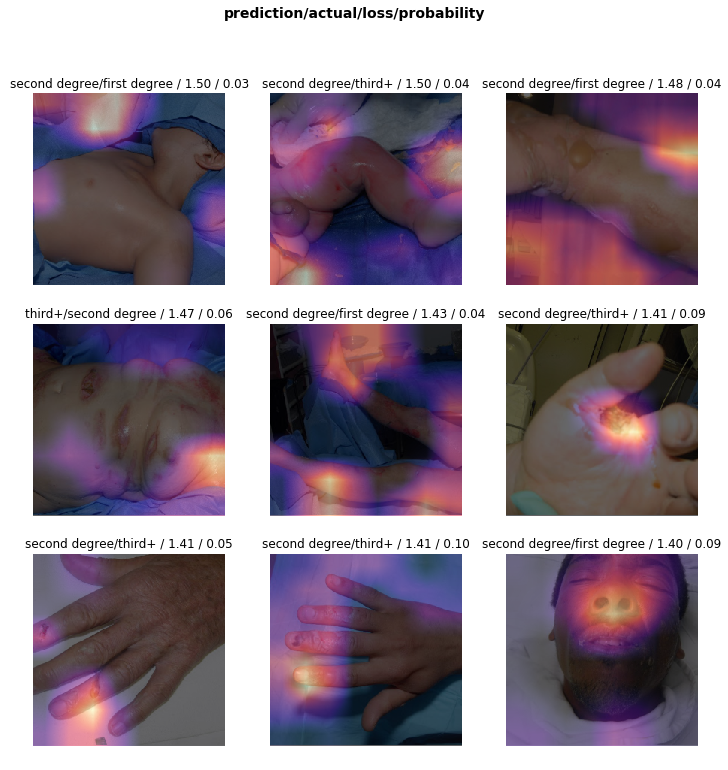

In [69]:
interp1.plot_top_losses(9, figsize=(12, 12))

# Resnet-152

Best accuracy 78% with TTA scale=0.85

## size=64

In [70]:
learn2 = cnn_learner(data64, models.resnet152, metrics=[accuracy]).mixup().to_fp16()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:10<00:00, 23489854.06it/s]


In [71]:
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


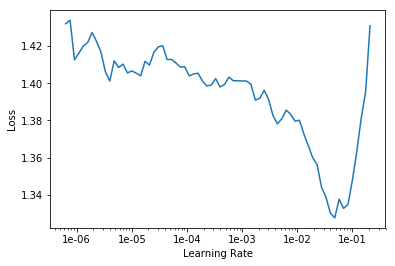

In [73]:
learn2.recorder.plot(skip_end=10)

In [74]:
learn2.fit_one_cycle(50, 1e-2, pct_start=0.3, callbacks=[SaveModelCallback(learn2, monitor='accuracy', name='152_64')])

Better model found at epoch 0 with accuracy value: 0.546875.
Better model found at epoch 3 with accuracy value: 0.578125.
Better model found at epoch 4 with accuracy value: 0.59375.
Better model found at epoch 5 with accuracy value: 0.6484375.
Better model found at epoch 14 with accuracy value: 0.65234375.
Better model found at epoch 16 with accuracy value: 0.67578125.
Better model found at epoch 17 with accuracy value: 0.70703125.
Better model found at epoch 44 with accuracy value: 0.72265625.
Better model found at epoch 45 with accuracy value: 0.7265625.


## size=128

In [76]:
learn2.to_fp32()
learn2.data = data128
learn2.to_fp16()
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


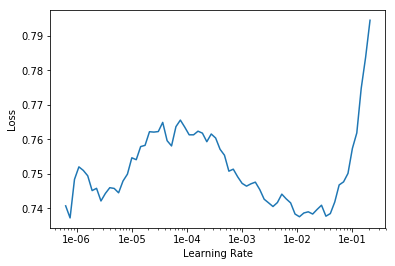

In [79]:
learn2.recorder.plot(skip_end=10)

In [80]:
learn2.fit_one_cycle(50, 3e-3, pct_start=0.3, callbacks=[SaveModelCallback(learn2, monitor='accuracy', name='152_128')])

Better model found at epoch 0 with accuracy value: 0.71875.
Better model found at epoch 1 with accuracy value: 0.7421875.
Better model found at epoch 3 with accuracy value: 0.75.
Better model found at epoch 4 with accuracy value: 0.7578125.
Better model found at epoch 6 with accuracy value: 0.78125.


## size=256

In [81]:
learn2.to_fp32()
learn2.data = data256
learn2.to_fp16()
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


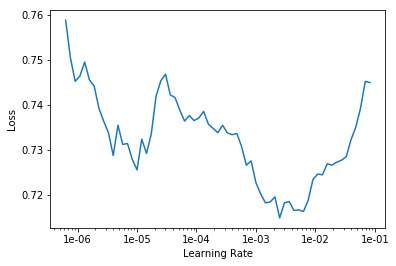

In [84]:
learn2.recorder.plot(skip_end=15)

In [85]:
learn2.fit_one_cycle(50, 3e-4, pct_start=0.3, callbacks=[SaveModelCallback(learn2, monitor='accuracy', name='152_256')])

Better model found at epoch 0 with accuracy value: 0.734375.
Better model found at epoch 1 with accuracy value: 0.73828125.
Better model found at epoch 4 with accuracy value: 0.75390625.
Better model found at epoch 8 with accuracy value: 0.76171875.
Better model found at epoch 10 with accuracy value: 0.76953125.
Better model found at epoch 14 with accuracy value: 0.7734375.


## TTA

In [87]:
learn2.to_fp32()
accs152 = []
for i in np.arange(0.7, 1.4, 0.05):
  accs152.append(
      (i, accuracy(*learn2.TTA(scale=i))))
sorted(accs152, key = lambda k: k[1], reverse=True)

[(0.8500000000000001, tensor(0.7773)),
 (1.0000000000000002, tensor(0.7773)),
 (1.0500000000000003, tensor(0.7773)),
 (0.7, tensor(0.7695)),
 (0.75, tensor(0.7695)),
 (0.9000000000000001, tensor(0.7695)),
 (1.1500000000000004, tensor(0.7695)),
 (1.1000000000000003, tensor(0.7656)),
 (0.9500000000000002, tensor(0.7617)),
 (1.2000000000000004, tensor(0.7617)),
 (1.3500000000000005, tensor(0.7617)),
 (0.8, tensor(0.7578)),
 (1.3000000000000005, tensor(0.7539)),
 (1.2500000000000004, tensor(0.7500))]

## Interpretation

In [88]:
interp2 = ClassificationInterpretation.from_learner2(learn2, scale=0.85)

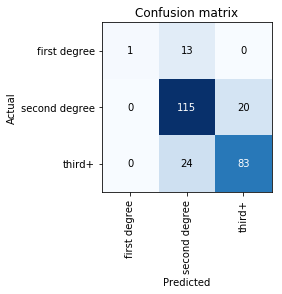

In [89]:
interp2.plot_confusion_matrix()

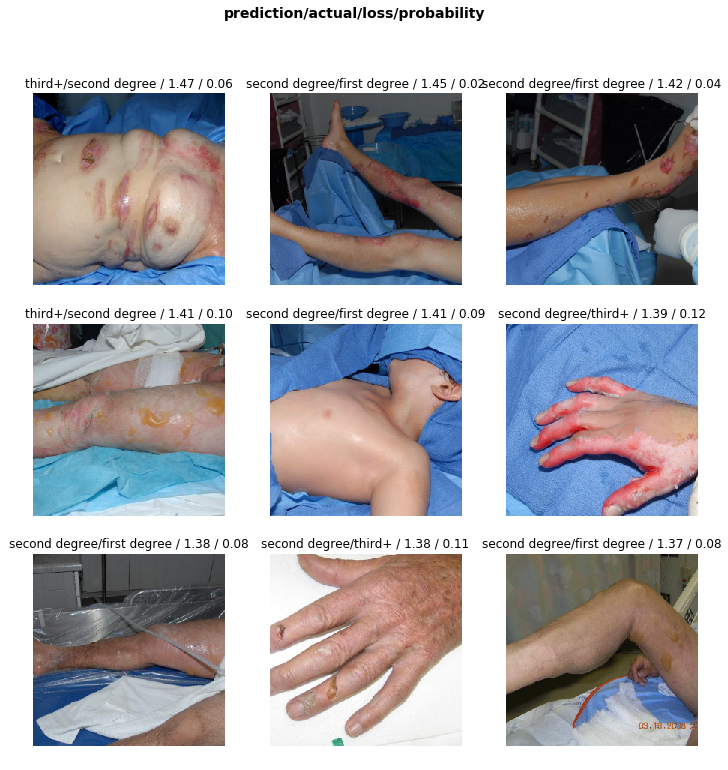

In [90]:
interp2.plot_top_losses(9, figsize=(12, 12), heatmap=False)

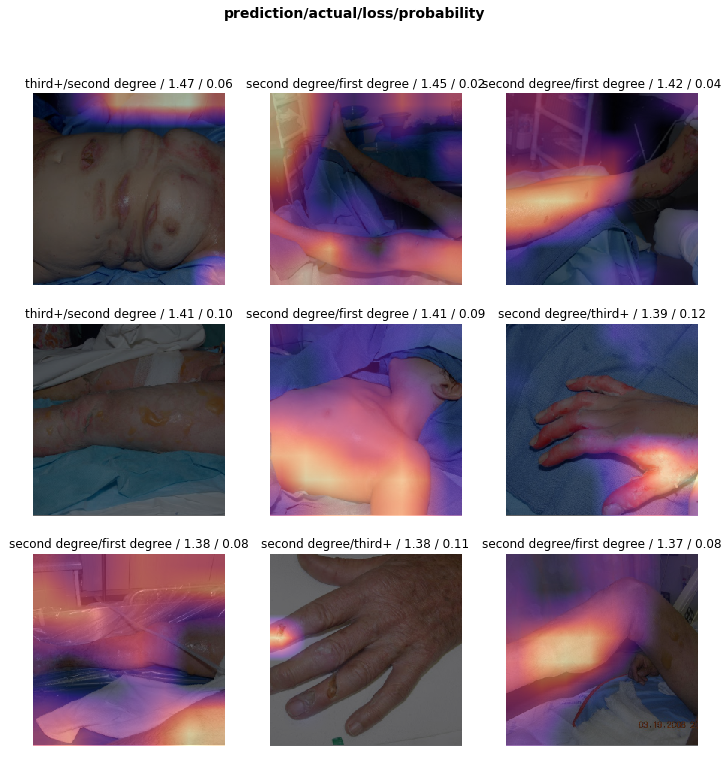

In [91]:
interp2.plot_top_losses(9, figsize=(12, 12))